## Pipeline to combine models

### Import

In [31]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import mlflow
from mlflow.transformers import log_model
import logging 
from mlflow.sklearn import save_model
import torch

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from mlflow.models.signature import infer_signature
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer
from scipy.special import softmax
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoModel, AutoTokenizer, AutoConfig


from torch import nn
import mlflow.pytorch

import sentencepiece
import os
import config

In [32]:
from basic_functions import (
    get_preprocess_data,
    get_lemmatized_data,
    tokenize,
    TextDataset,
    get_metrics
)

### Setup


In [33]:
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

### Prepare for LogReg

In [34]:
def get_vectorizer(data_path):
    df = get_preprocess_data(data_path)
    df = get_lemmatized_data(df)

    X = df['text']
    y = df['logical_fallacies']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y)

    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),  # Bigrams (or even trigrams)
        max_features=1000,   # Limit feature space to the most important words
        min_df=5,            # Consider words that appear in at least 5 documents
        max_df=0.9)       # Ignore words that appear in more than 90% of documents)
        
    return tfidf_vectorizer.fit(X_train)



In [35]:
binary_vectorizer = get_vectorizer("../data/data_binary.csv")
binary_emotion_hominem_vectorizer = get_vectorizer("../data/data_binary_emotion_hominem.csv")
multiclass_with_vectorizer = get_vectorizer("../data/data_multiclass_with_none.csv")
multiclass_without_vectorizer = get_vectorizer("../data/data_multiclass_without_none.csv")

In [36]:
def get_vectorized_text(df, problem_type):

    df['text'] = df['text'].apply(lambda x: x.lower())
    df = get_lemmatized_data(df)

    # if (problem_type == 'multiclass_with') or (problem_type == 'multiclass_without'):
    #     y = df['logical_fallacies']
    # else:
    #     y = df['two_class_target']
    X = df['text']

    if problem_type == 'multiclass_with':
        X_vectorized = multiclass_with_vectorizer.transform(X)
    elif problem_type == 'multiclass_without':
        X_vectorized = multiclass_without_vectorizer.transform(X)
    elif problem_type == 'binary':
        X_vectorized = binary_vectorizer.transform(X)
    else:
        X_vectorized = binary_emotion_hominem_vectorizer.transform(X)

    return X_vectorized


### Prepare for DistilBert

In [37]:
# le = LabelEncoder()
# y = df['logical_fallacies']
# # y = df['two_class_target']
# y_encoded = le.fit_transform(y)

def get_tokenized_text(df):
    X = df['text']
    x_tokenized = tokenize(X.to_list(), "distilbert-base-uncased")
    return x_tokenized


### Distilbert Prediction

In [38]:
## Function for prediction

def predict(model, encodings, batch_size=8):
    # Set the model to evaluation mode
    model.eval()
    
    # Use GPU
    device = torch.device("mps")
    model.to(device)
    
    # Perform inference
    probabilities = []
    for i in range(0, len(encodings["input_ids"]), batch_size):
        with torch.no_grad():
            batch = {
                key: val[i:i+batch_size].to(device) 
                for key, val in encodings.items()
            }
            outputs = model(**batch)
            probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
            probabilities.extend(probs)
            
        # Clear GPU memory after each batch
        torch.mps.empty_cache()
    
    return np.array(probabilities)

### Pipeline: Binary LogReg + Multiclass DistilBert

In [ ]:
MODEL_NAME = "binary_LogReg_multiclass_DistilBert" 

#setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "binary logreg multi distilbert")
mlflow.log_param("dataset", 'data_val')


#### 1. Step: Binary LogReg

In [ ]:
#Get Val-Data and prepare for binary logreg
df_val = pd.read_csv('../data/data_val.csv')
X_prep = get_vectorized_text(df_val, 'binary')

In [ ]:
#Import LogReg Binary Model
with open("../models/logreg_binary/logreg_binary.pkl", "rb") as file:
    logreg_binary = pickle.load(file)

In [ ]:
y_pred = logreg_binary.predict(X_prep)

In [ ]:
#Create dataframe for next step
df_second = df_val.copy()
df_second["pred_1"]=y_pred
df_second = df_second[df_second['pred_1']== 'fallacy']

In [ ]:
df_second.head()

In [ ]:
df_second.shape

#### 2.step: Distilbert Multiclass without none

In [ ]:
# prepare X for Distilbert
X_prep_2 = get_tokenized_text(df_second)

In [ ]:
#load Distilbert
path_pt = "../models/distilbert_multiclass_without_none/pytorch_model"
distilbert = mlflow.pytorch.load_model(path_pt)


In [ ]:
base_probs = predict(distilbert, X_prep_2, batch_size=2)

In [ ]:
def get_first_prediction(proba):
    pred = np.argmax(proba, axis=1)
    pred_int = int(pred[0])
    proba = proba[np.arange(len(pred)), pred]
    proba_int = float(proba[0])
    return pred_int, proba_int

In [ ]:
first_pred, first_proba = get_first_prediction(base_probs)


#### Evaluation

In [ ]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                print(f"{split}_{key}_{metric}", round(value.get(metric),2))

In [ ]:
logger.info('get validation metrics for one-step approach')
classification_report_one_train = get_metrics(df_second['logical_fallacies'], y_train_pred_one)
log_metrics(classification_report_one_train, 'val')

In [ ]:
mlflow.end_run()

### Pipeline: Binary LogReg + Multi LogReg

In [67]:
MODEL_NAME = "binary_LogReg_multiclass_LogReg" 

#setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "binary logreg multi logreg")
mlflow.log_param("dataset", 'data_val')


Active run_id: 5d2691f31d83482d80d7fb2cc7e93e65


'data_val'

#### 1. Step: Binary LogReg

In [68]:
#Get Val-Data and prepare for binary logreg
df_val = pd.read_csv('../data/data_val.csv')
X_prep = get_vectorized_text(df_val, 'binary')

In [69]:
#Import LogReg Binary Model
with open("../models/logreg_binary/logreg_binary.pkl", "rb") as file:
    logreg_binary = pickle.load(file)

In [70]:
y_pred = logreg_binary.predict(X_prep)

In [71]:
#Create dataframe for next step
# df_second = df_val.copy()
df_first= df_val.copy()
df_first['pred_1'] = y_pred
df_second = df_first[df_first['pred_1']== 'fallacy']
df_first = df_first[df_first['pred_1'] == 'none']

In [72]:
df_first.head()

,dataset,text,logical_fallacies,source,two_class_target,pred_1
2,3,i understand turkey s position here they can t...,false_dilemma,NaN,fallacy,none
3,3,i don t know why the international community e...,false_dilemma,NaN,fallacy,none
4,1,if it is very low for instance around one it m...,false_dilemma,http://business.financialpost.com/opinion/ross...,fallacy,none
6,3,the people who live in these area like the car...,false_dilemma,NaN,fallacy,none
9,3,with fake drug on the market it could end up b...,false_dilemma,NaN,fallacy,none


In [73]:
df_second.head()

,dataset,text,logical_fallacies,source,two_class_target,pred_1
0,3,either the prime minister let independent medi...,false_dilemma,NaN,fallacy,fallacy
1,3,turkey really need to get rid of erdogan and h...,false_dilemma,NaN,fallacy,fallacy
5,3,they can oppose or support the curfew that won...,false_dilemma,NaN,fallacy,fallacy
7,3,great job for the lockdown measure it s either...,false_dilemma,NaN,fallacy,fallacy
8,1,mann who testifies before congress this week i...,false_dilemma,https://www.washingtonpost.com/news/energy-env...,fallacy,fallacy


In [57]:
df_second['pred_1'].unique()

array(['fallacy'], dtype=object)

In [58]:
df_second['logical_fallacies'].value_counts()

logical_fallacies
appeal_to_emotion      211
ad_hominem             191
false_dilemma          186
appeal_to_authority    171
none                   170
slippery_slope          60
Name: count, dtype: int64

#### 2.step: LogReg Multiclass without none

In [74]:
#Get Val-Data and prepare for binary logreg
X_prep = get_vectorized_text(df_second, 'multiclass_without')

In [75]:
#Import LogReg Binary Model
with open("../models/logreg_multi_without/logreg_multi_without.pkl", "rb") as file:
    logreg_multi_without = pickle.load(file)

In [76]:
y_pred = logreg_multi_without.predict(X_prep)

In [77]:
df_second['pred_2']=y_pred

In [78]:
df_second = df_second.drop('source', axis=1)

In [79]:
df_first= df_first.drop('source', axis=1)

In [81]:
df_first['pred_2'] = df_first['pred_1']

In [82]:
df_result = pd.concat([df_first, df_second], ignore_index=True)

In [83]:
df_result

,dataset,text,logical_fallacies,two_class_target,pred_1,pred_2
0,3,i understand turkey s position here they can t...,false_dilemma,fallacy,none,none
1,3,i don t know why the international community e...,false_dilemma,fallacy,none,none
2,1,if it is very low for instance around one it m...,false_dilemma,fallacy,none,none
3,3,the people who live in these area like the car...,false_dilemma,fallacy,none,none
4,3,with fake drug on the market it could end up b...,false_dilemma,fallacy,none,none
...,...,...,...,...,...,...
1345,3,protesting to make it easier on people who are...,slippery_slope,fallacy,fallacy,slippery_slope
1346,3,this is all interesting to know for historical...,slippery_slope,fallacy,fallacy,appeal_to_authority
1347,3,it s easy to understand why people are upset i...,slippery_slope,fallacy,fallacy,slippery_slope
1348,9,then he go on to say that he s going to change...,slippery_slope,fallacy,fallacy,slippery_slope


#### Evaluation

In [84]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                print(f"{split}_{key}_{metric}", round(value.get(metric),2))

INFO:root:get validation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.58      0.41      0.48       250
appeal_to_authority       0.53      0.49      0.51       250
  appeal_to_emotion       0.56      0.56      0.56       250
      false_dilemma       0.65      0.55      0.60       250
               none       0.22      0.32      0.26       250
     slippery_slope       0.39      0.46      0.42       100

           accuracy                           0.47      1350
          macro avg       0.49      0.46      0.47      1350
       weighted avg       0.50      0.47      0.48      1350

[[102  26  38  22  59   3]
 [ 10 122  21   8  79  10]
 [ 30  24 140   8  39   9]
 [ 10  12  12 138  64  14]
 [ 23  39  39  34  80  35]
 [  2   8   1   3  40  46]]


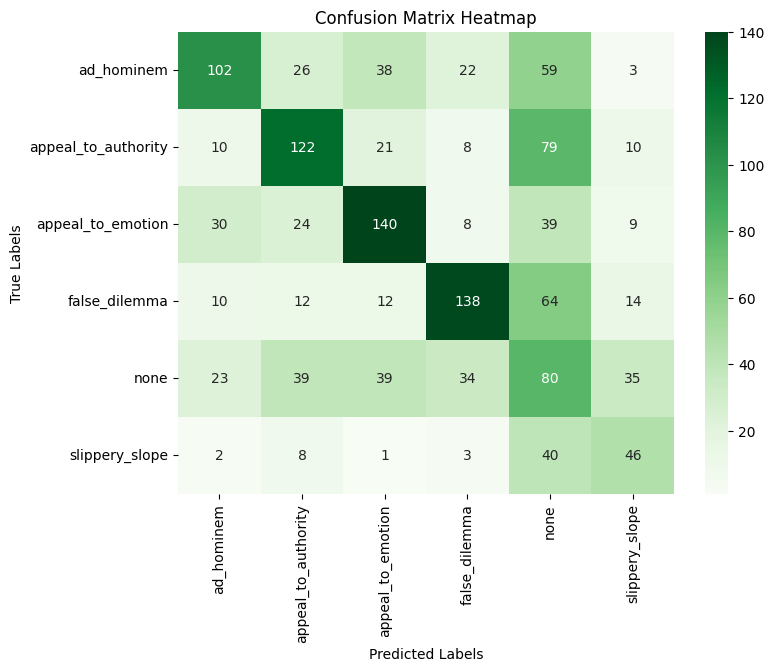

val_ad_hominem_precision 0.58
val_ad_hominem_recall 0.41
val_ad_hominem_f1-score 0.48
val_ad_hominem_support 250
val_appeal_to_authority_precision 0.53
val_appeal_to_authority_recall 0.49
val_appeal_to_authority_f1-score 0.51
val_appeal_to_authority_support 250
val_appeal_to_emotion_precision 0.56
val_appeal_to_emotion_recall 0.56
val_appeal_to_emotion_f1-score 0.56
val_appeal_to_emotion_support 250
val_false_dilemma_precision 0.65
val_false_dilemma_recall 0.55
val_false_dilemma_f1-score 0.6
val_false_dilemma_support 250
val_none_precision 0.22
val_none_recall 0.32
val_none_f1-score 0.26
val_none_support 250
val_slippery_slope_precision 0.39
val_slippery_slope_recall 0.46
val_slippery_slope_f1-score 0.42
val_slippery_slope_support 100
val_accuracy 0.47
val_macro avg_precision 0.49
val_macro avg_recall 0.46
val_macro avg_f1-score 0.47
val_macro avg_support 1350
val_weighted avg_precision 0.5
val_weighted avg_recall 0.47
val_weighted avg_f1-score 0.48
val_weighted avg_support 1350


In [85]:
logger.info('get validation metrics')
classification_report = get_metrics(df_result['logical_fallacies'], df_result['pred_2'])
log_metrics(classification_report, 'val')

In [ ]:
mlflow.end_run()